# Initial Analysis on Olists' Current Financial Performance

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
%load_ext autoreload
%autoreload 2
from olist.seller import Seller
from olist.data import Olist
from olist.utils import *
from olist.product import Product
from olist.order import Order

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [5]:
product = Product().get_training_data()
seller = Seller().get_training_data()
order = Order().get_training_data(with_distance_seller_customer=True)

## P&L Rules

For each `seller_id` we need three items:  

- The **revenue**:

    - 10% fee on sales
    - 80 BRL per month on Olist

- The **cost**:
    - Review cost according to `{1: 100, 2: 50, 3: 40, 4: 0, 5: 0}` with review score as key and cost in BRL as value

- The **profit** made by Olist


## Calculating the Total Revenue, IT Cost, Reputation Cost, and Profit

In [7]:
#calculating the revenue
subscription_revenue = (seller['months_on_olist']*80).sum()
sales_revenue = (seller['sales']*0.1).sum()

#calculating the it cost
n_sellers = seller.nunique()['seller_id']
n_items = seller['quantity'].sum()
it_cost = 3157.27*sqrt(n_sellers) + 978.23*sqrt(n_items)

#calculating the total reputation cost
reputation_cost = seller['cost_of_reviews'].sum()

#calculating the gross profit
gross_profit = subscription_revenue + sales_revenue - reputation_cost - it_cost

financials = pd.DataFrame([
    ('Subscription Revenue',subscription_revenue),
    ('Sales Revenue',sales_revenue),
    ('Total Revenue',subscription_revenue + sales_revenue),
    ('IT Cost',it_cost),
    ('Reputation Cost',reputation_cost),
    ('Total Cost',it_cost + reputation_cost),
    ('Gross Profit',gross_profit),
    ('Profit Margin',gross_profit/(subscription_revenue + sales_revenue))]
)

financials.rename(columns = {0:'Items',1:'in BRL'},inplace=True)
financials_formatted = financials.round(2)
#financials_formatted[['in BRL']] = financials_formatted[['in BRL']].applymap(lambda x: "{:,}".format(x))


**Current financials look like this:**

In [8]:
financials_formatted

,Items,in BRL
0,Subscription Revenue,1430240.00
1,Sales Revenue,1355578.44
2,Total Revenue,2785818.44
3,IT Cost,499999.32
4,Reputation Cost,1618210.00
5,Total Cost,2118209.32
6,Gross Profit,667609.13
7,Profit Margin,0.24


In [11]:
# Create DataFrame
data = {
    'Items': ['Subscription Revenue', 'Sales Revenue', 'Total Revenue', 'IT Cost', 'Reputation Cost', 'Total Cost', 'Gross Profit', 'Profit Margin'],
    'in BRL': ['1,430,240.0', '1,355,578.44', '2,785,818.44', '499,999.32', '1,618,210.0', '2,118,209.32', '667,609.13', '0.24']
}

financials_formatted = pd.DataFrame(data)

# Convert 'in BRL' to numeric, removing commas
financials_formatted['in BRL'] = financials_formatted['in BRL'].str.replace(',', '').astype(float)

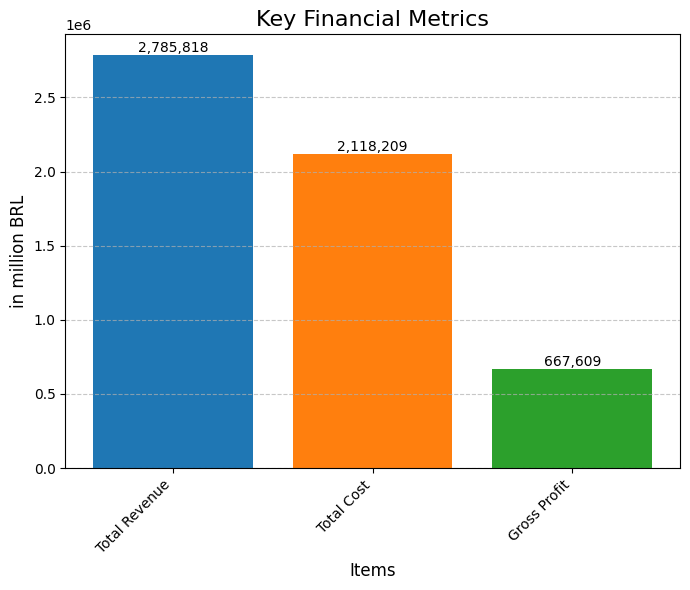

In [12]:
plt.figure(figsize=(7, 6))
items_to_plot = ['Total Revenue', 'Total Cost', 'Gross Profit']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.bar(financials_formatted[financials_formatted['Items'].isin(items_to_plot)]['Items'], 
        financials_formatted[financials_formatted['Items'].isin(items_to_plot)]['in BRL'],
        color=colors)

plt.title('Key Financial Metrics', fontsize=16)
plt.xlabel('Items', fontsize=12)
plt.ylabel('in million BRL', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(financials_formatted[financials_formatted['Items'].isin(items_to_plot)]['in BRL']):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Revenue and Cost Breakdown**

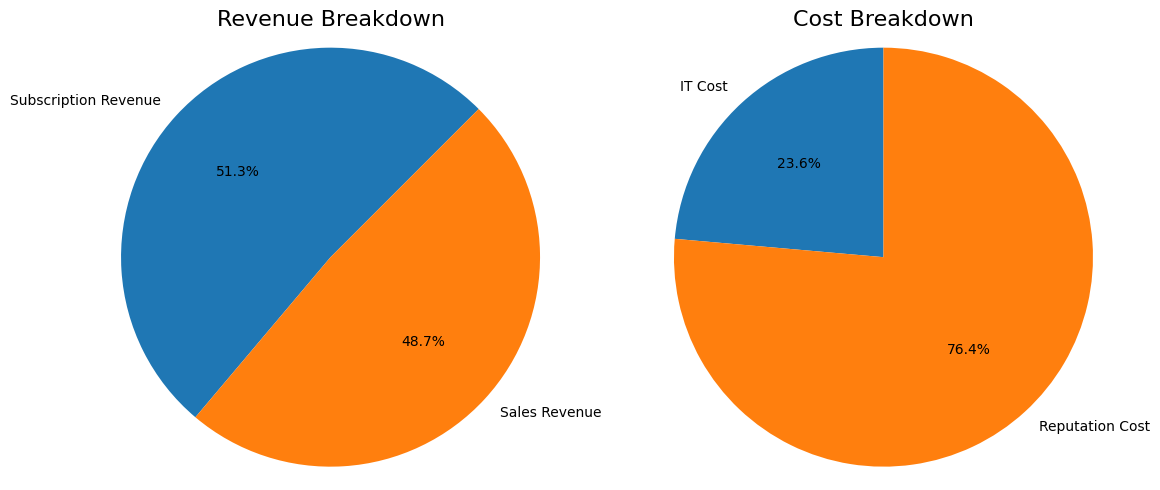

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Revenue Breakdown
revenue_data = financials_formatted[financials_formatted['Items'].isin(['Subscription Revenue', 'Sales Revenue'])]
axs[0].pie(revenue_data['in BRL'], labels=revenue_data['Items'], autopct='%1.1f%%', 
            startangle=45, labeldistance=1.1)  # Adjust labeldistance
axs[0].set_title('Revenue Breakdown', fontsize=16)
axs[0].axis('equal')

# Plot 2: Cost Breakdown
cost_data = financials_formatted[financials_formatted['Items'].isin(['IT Cost', 'Reputation Cost'])]
axs[1].pie(cost_data['in BRL'], labels=cost_data['Items'], autopct='%1.1f%%', 
            startangle=90, labeldistance=1.1)  # Adjust labeldistance
axs[1].set_title('Cost Breakdown', fontsize=16)
axs[1].axis('equal')

plt.tight_layout()
plt.show()



Key things to note:
- Total Revenue is around **2.8M BRL** - well diversified with around half from subscription and around half from sales
- REPUTATION COSTS ARE VERY DAMAGING
- Reputation Costs make up of more than **76%** of total costs $\rightarrow$ risk of losing more customers in the future!!

What if we simply remove the worst sellers?

In [14]:
sorted_sellers = seller.sort_values(by='profits', ascending=True, ignore_index=True)
def it_cost_recalc(df,num_to_remove):
    n_sellers = seller.nunique()['seller_id'] - num_to_remove
    n_items = df['quantity'].sum() - df['quantity'].values[:num_to_remove].sum()
    
    it_cost = 3157.27* sqrt(n_sellers) + 978.23*sqrt(n_items)
    return it_cost
change_in_it_cost = pd.DataFrame([it_cost_recalc(sorted_sellers,num) for num in range(2967)])
change_in_profit = pd.DataFrame([sorted_sellers['profits'].values[num:].sum() for num in range(2967)])
change_in_revenue= pd.DataFrame([sorted_sellers['revenues'].values[num:].sum() for num in range(2967)])
change_in_rep_cost = pd.DataFrame([sorted_sellers['cost_of_reviews'].values[num:].sum() for num in range(2967)])
change_in_profit_after_it = change_in_profit - change_in_it_cost
change_in_it_cost
change_in_it_cost[0]

0       499999.318519
1       496991.389117
2       494024.237152
3       491347.711731
4       489511.812301
            ...      
2962     51383.513743
2963     44339.889079
2964     41224.163282
2965     31254.985925
2966     22964.917828
Name: 0, Length: 2967, dtype: float64

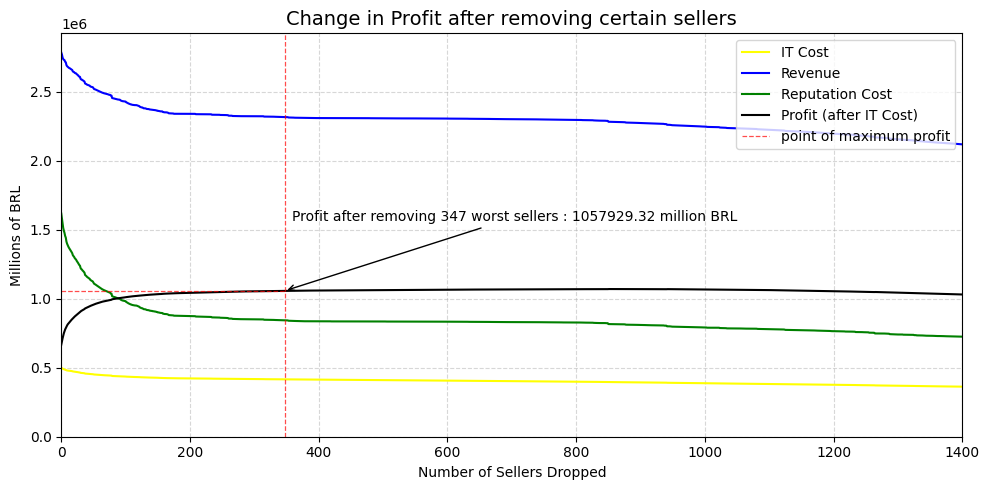

In [8]:
plt.figure(figsize=(10, 5))

# Plotting the lines
sns.lineplot(x=change_in_it_cost.index, y=change_in_it_cost[0], label='IT Cost', color='yellow', linestyle='-')
sns.lineplot(x=change_in_revenue.index, y=change_in_revenue[0], label='Revenue', color='blue', linestyle='-')
sns.lineplot(x=change_in_rep_cost.index, y=change_in_rep_cost[0], label='Reputation Cost', color='green', linestyle='-')
sns.lineplot(x=change_in_profit_after_it.index, y=change_in_profit_after_it[0], label='Profit (after IT Cost)', color='black', linestyle='-')

# Adding vertical line
plt.axvline(x=347, color='red', linestyle='--', label='point of maximum profit',linewidth=0.9, alpha=0.7)

# Formatting
plt.xlim(0, 1400)
plt.ylim(0, None)  # Adjust ylim as needed
plt.xlabel('Number of Sellers Dropped')
plt.ylabel('Millions of BRL')
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines
plt.legend(loc='upper right', frameon=True)  # Adjust legend position and style

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding annotation for y-value at x = 347
x_annotation = 347
y_annotation = change_in_profit_after_it.loc[x_annotation][0]
plt.annotate(f'Profit after removing 347 worst sellers : {y_annotation:.2f} million BRL',
             xy=(x_annotation, y_annotation), xycoords='data',
             xytext=(5, 50), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

# Adding horizontal line perpendicular to y = 347 line
plt.plot([0, x_annotation], [y_annotation, y_annotation], color='red', linestyle='--',linewidth=0.9, alpha=0.7)


# Title
plt.title('Change in Profit after removing certain sellers', fontsize=14)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

**You can expect to increase profit by 390K BRL just be removing the worst 347 sellers!**

Why?
- number of products and number of sellers are also driving factors of getting low review scores
- There are also chances of penalizing sellers and products that were bundle purchased with bad products/bad sellers

In [ ]:
plt.figure(figsize=(5,3))
logit_model.params[1:].sort_values().plot(kind='barh')
plt.xlabel('logistic regression coefficient')
plt.ylabel('features')
plt.title('order features logistically regressed against probability of getting a review score of 1');

In [ ]:
product['product_volume_cm3'] = product["product_length_cm"] * product["product_height_cm"] * product["product_width_cm"]
product_features =  [
    'product_photos_qty',
    'product_volume_cm3',
    'wait_time',
    'price',
]
product_logit_features = [
    'product_photos_qty',
    'product_volume_cm3',
    'wait_time',
    'price',
    'review_score'
]
standardized_products = standardize(product,product_features)

In [ ]:
formula = 'review_score' + ' ~ ' + ' + '.join(product_features)
product_model = smf.ols(formula = formula,data=standardized_products).fit()
product_model.summary()

In [ ]:
product_model.params[1:].sort_values().plot(kind='barh')
plt.title('product features linearly regressed against review_score');

## Thank you for listening!
## Hope you make the right decision!